# Labelling

## Libraries Import

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Import Data and Functions

In [ ]:
data = pd.read_csv('../../data/SP_futures_tick_data.csv')
#combine 'date' and 'time' strings into one column
datetime_str = data['date'] + ' ' + data['time']
#convert the combined string to datetime format
data['datetime'] = pd.to_datetime(datetime_str, errors='coerce')

In [6]:
#restrict to 2014 to 2019
#after 2013
data = data[data.datetime.dt.year >= 2014]
#before 2019
data = data[data.datetime.dt.year <= 2018]
#drop date and time 
data = data.drop(['date','time'],axis=1)
print(f'Now, data starts at {data.datetime.iloc[0]} and ends at {data.datetime.iloc[-1]}')
data = data.reset_index()
data = data.drop('index',axis=1)
data.head()


Now, data starts at 2014-01-02 05:00:00.028000 and ends at 2018-12-31 15:49:46.582000


,price,volume,datetime
0,1837.9,1,2014-01-02 05:00:00.028
1,1837.9,3,2014-01-02 05:00:00.028
2,1837.9,1,2014-01-02 05:00:00.028
3,1837.9,2,2014-01-02 05:00:00.028
4,1837.9,1,2014-01-02 05:00:00.028


In [23]:
#import functions from my scripts and book scripts

sys.path.append('../../scripts')
from AFML_my_scripts import TickBarsDf,VolumeBarsDf, VolumeBarsDfVectorized, DollarBarsDfVectorized, GetTargetforTBM
from AFML_book_scripts import GetDailyVol,applyTPSLOnT1,getEvents, getTBMLabels, getEventsMeta, getTBMLabelsMeta


## 3.3 COMPUTING DYNAMIC THRESHOLD

In [8]:
bars = VolumeBarsDfVectorized(data,volume_per_bar=500)
bars = bars.rename(columns={'end_date':'datetime'})
bars = bars.drop('start_date',axis=1)
bars = bars.set_index('datetime')
bars

,open,high,low,close,volume
datetime,,,,,
2014-01-02 07:39:10.097,1837.9,1840.5,1834.4,1837.3,501
2014-01-03 05:26:12.557,1836.9,1837.0,1821.0,1827.4,503
2014-01-03 07:06:57.829,1827.4,1830.0,1827.1,1829.7,496
2014-01-06 03:44:44.566,1829.7,1832.5,1823.2,1826.0,500
2014-01-06 04:09:19.532,1825.8,1827.1,1825.7,1826.2,501
...,...,...,...,...,...
2018-12-12 08:01:34.582,2615.2,2675.4,2587.0,2674.1,495
2018-12-20 04:20:27.086,2671.0,2685.0,2480.3,2504.1,500
2018-12-23 17:19:38.316,2505.0,2516.5,2405.5,2406.0,501


In [9]:
#calculate daily volatility and add it to the bars DataFrame
bars['daily_vol'] = GetDailyVol(bars['close'], span0=100)
bars.head()

,open,high,low,close,volume,daily_vol
datetime,,,,,,
2014-01-02 07:39:10.097,1837.9,1840.5,1834.4,1837.3,501,NaN
2014-01-03 05:26:12.557,1836.9,1837.0,1821.0,1827.4,503,NaN
2014-01-03 07:06:57.829,1827.4,1830.0,1827.1,1829.7,496,NaN
2014-01-06 03:44:44.566,1829.7,1832.5,1823.2,1826.0,500,NaN
2014-01-06 04:09:19.532,1825.8,1827.1,1825.7,1826.2,501,0.000077


## 3.4 TRIPLE-BARRIER METHOD 

The main idea would be to:

1. Apply first a filter (ex CUSUM)
2. Use another function to get specific events when the dataset is big --> GetEvents
3. Calculate a dynamic target for positioning  --> GetTargetforTBM or GetDailyVol
4. Use TBM --> applyTPSLOnT1 

In example 1 we will skip steps 1,2,3
In example 2 we will skip steps 1,2
In example 3 we will skip step 1

*In exercises we will use all steps!!!*

### Example 1: TBM on all events with fixed target

In [11]:
#here we label the entire dataset
close = bars['close'] #closing prices series indexed by datetime
events = pd.DataFrame(index = bars.close.index)
events['t1'] = close.index.to_series().shift(-10) #set vert barrier 10 bars ahead
target = 0.02 #2% fixed as target 
events['trgt'] = target #target calcualted by gettarget
events['side'] = 1  #long only
tpsl_here = (1,1) #symmetric positioning tp and sl
events.head()

,t1,trgt,side
datetime,,,
2014-01-02 07:39:10.097,2014-01-10 03:13:10.983,0.02,1
2014-01-03 05:26:12.557,2014-01-10 03:52:38.319,0.02,1
2014-01-03 07:06:57.829,2014-01-13 03:24:46.721,0.02,1
2014-01-06 03:44:44.566,2014-01-14 02:03:24.176,0.02,1
2014-01-06 04:09:19.532,2014-01-14 07:20:58.569,0.02,1


In [12]:
out1 = applyTPSLOnT1(close, events, tpsl_here, molecule=events.index) #note that molecule is the index of events --> no parallelization here
out1

,t1,sl,tp
datetime,,,
2014-01-02 07:39:10.097,2014-01-10 03:13:10.983,NaT,NaT
2014-01-03 05:26:12.557,2014-01-10 03:52:38.319,NaT,NaT
2014-01-03 07:06:57.829,2014-01-13 03:24:46.721,NaT,NaT
2014-01-06 03:44:44.566,2014-01-14 02:03:24.176,NaT,NaT
2014-01-06 04:09:19.532,2014-01-14 07:20:58.569,NaT,NaT
...,...,...,...
2018-12-12 08:01:34.582,NaT,2018-12-20 04:20:27.086,NaT
2018-12-20 04:20:27.086,NaT,2018-12-23 17:19:38.316,NaT
2018-12-23 17:19:38.316,NaT,2018-12-25 22:57:15.141,2018-12-27 18:36:12.027


### Example 2: All events but with dynamic target

In [13]:
target = GetTargetforTBM(bars['close'], ema_periods=20)
events['trgt'] = target #target calcualted by gettarget
events['side'] = 1  #long only
tpsl_here = (1,1) #symmetric positioning tp and sl
events.head()

,t1,trgt,side
datetime,,,
2014-01-02 07:39:10.097,2014-01-10 03:13:10.983,0.004710,1
2014-01-03 05:26:12.557,2014-01-10 03:52:38.319,0.004710,1
2014-01-03 07:06:57.829,2014-01-13 03:24:46.721,0.004710,1
2014-01-06 03:44:44.566,2014-01-14 02:03:24.176,0.003247,1
2014-01-06 04:09:19.532,2014-01-14 07:20:58.569,0.002799,1


In [14]:
out2 = applyTPSLOnT1(close, events, tpsl_here, molecule=events.index) #note that molecule is the index of events --> no parallelization here
out2

,t1,sl,tp
datetime,,,
2014-01-02 07:39:10.097,2014-01-10 03:13:10.983,2014-01-03 05:26:12.557,NaT
2014-01-03 05:26:12.557,2014-01-10 03:52:38.319,NaT,2014-01-09 05:57:48.659
2014-01-03 07:06:57.829,2014-01-13 03:24:46.721,NaT,NaT
2014-01-06 03:44:44.566,2014-01-14 02:03:24.176,2014-01-14 02:03:24.176,2014-01-09 05:57:48.659
2014-01-06 04:09:19.532,2014-01-14 07:20:58.569,2014-01-14 02:03:24.176,2014-01-09 05:57:48.659
...,...,...,...
2018-12-12 08:01:34.582,NaT,2018-12-20 04:20:27.086,NaT
2018-12-20 04:20:27.086,NaT,2018-12-23 17:19:38.316,NaT
2018-12-23 17:19:38.316,NaT,2018-12-25 22:57:15.141,2018-12-27 18:36:12.027


### Example 3: Filter events and dynamic target

In [ ]:
# t1 can be passed as argument in GetEvents

#some sampled events (here is just a slice of the close index)
tEvents = close.index[100:300]
# numDays is the max holding period (vertical barrier)
numDays = 10  # max holding period in days

t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
t1=t1[t1<close.shape[0]]
t1=pd.Series(close.index[t1],index=tEvents[:t1.shape[0]])
minRet = 0.005
ptSl = (1,1)

In [18]:
events = getEvents(close, tEvents, ptSl, target, minRet, t1=t1)  # getEvents function call with t1
events.head()

,t1,trgt
datetime,,
2014-03-14 01:04:26.864,2014-03-18 05:52:22.932,0.005207
2014-03-14 07:34:18.142,2014-03-17 06:01:45.218,0.005014
2014-03-26 06:15:07.905,2014-03-27 03:32:34.982,0.005061
2014-03-27 03:32:34.982,2014-03-31 00:58:36.916,0.006049
2014-03-28 02:45:30.656,2014-03-31 00:58:36.916,0.005761


In [20]:
out = getTBMLabels(events, close)
out.head()

,ret,bin,t1
datetime,,,
2014-03-14 01:04:26.864,0.005273,1.0,2014-03-18 05:52:22.932
2014-03-14 07:34:18.142,0.005019,1.0,2014-03-17 06:01:45.218
2014-03-26 06:15:07.905,-0.011577,-1.0,2014-03-27 03:32:34.982
2014-03-27 03:32:34.982,0.007429,1.0,2014-03-31 00:58:36.916
2014-03-28 02:45:30.656,0.007156,1.0,2014-03-31 00:58:36.916


### Plot of Events on Close Series

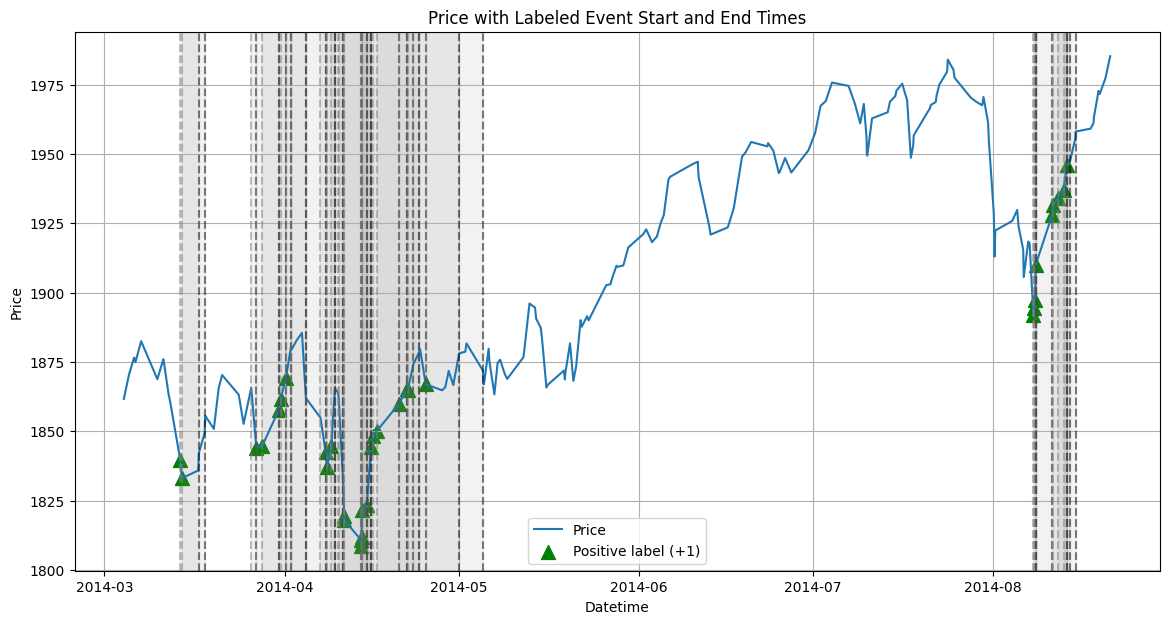

In [21]:
events_labeled = out
close_plot = close.copy()[100:300]  # slice for plotting

plt.figure(figsize=(14,7))
plt.plot(close_plot.index, close_plot.values, label='Price')

# Filter events by label within the plotting range
pos_events = events_labeled[(events_labeled['bin'] == 1) & (events_labeled.index.isin(close_plot.index))]
neg_events = events_labeled[(events_labeled['bin'] == -1) & (events_labeled.index.isin(close_plot.index))]
neutral_events = events_labeled[(events_labeled['bin'] == 0) & (events_labeled.index.isin(close_plot.index))]

# Plot event markers on price chart
plt.scatter(pos_events.index, close.loc[pos_events.index], color='green', marker='^', label='Positive label (+1)', s=100)
#plt.scatter(neg_events.index, close.loc[neg_events.index], color='red', marker='v', label='Negative label (-1)', s=100)
#plt.scatter(neutral_events.index, close.loc[neutral_events.index], color='blue', marker='o', label='Neutral label (0)', s=50)

# Add vertical lines and shaded areas for events (only those fully inside the plot range)
for start_time, row in events_labeled.iterrows():
    end_time = row['t1']
    if start_time in close_plot.index and end_time in close_plot.index:
        plt.axvline(start_time, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(end_time, color='black', linestyle='--', alpha=0.5)
        
        # Shade between start and end times
        plt.axvspan(start_time, end_time, color='gray', alpha=0.1)

plt.legend()
plt.title('Price with Labeled Event Start and End Times')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.grid(True)
plt.show()


## 3.5 META-LABELLING

No tests here, you can check in the projects folder